In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

# For handling imbalance
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# %% 
# Custom modules
from model_builder import train_model
from feature_engineering import engineer_features

In [2]:
PROCESSED_DIR = os.path.abspath(os.path.join("..", "data", "processed"))
CLEANED_PATH = os.path.join(PROCESSED_DIR, "cleaned_customer_churn.csv")
ENGINEERED_PATH = os.path.join(PROCESSED_DIR, "engineered_customer_churn.csv")
PREDICTIONS_DIR = os.path.join(PROCESSED_DIR, "predictions")
FEATURE_IMPORTANCE_DIR = os.path.join(PROCESSED_DIR, "feature_importance")
METRICS_DIR = os.path.join(PROCESSED_DIR, "metrics")
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(FEATURE_IMPORTANCE_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

In [3]:
df_cleaned = pd.read_csv(CLEANED_PATH)
print(f"Loaded cleaned data: {df_cleaned.shape}")

Loaded cleaned data: (7032, 20)



Class distribution BEFORE balancing:
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


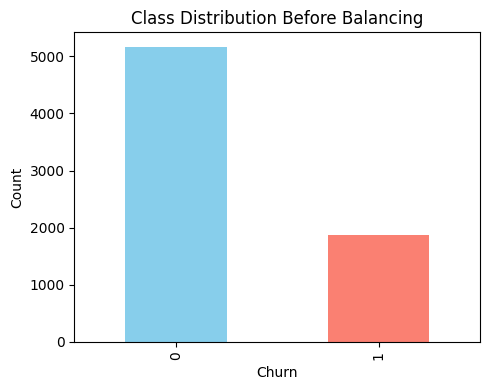

In [4]:
# %% Class imbalance before
print("\nClass distribution BEFORE balancing:")
print(df_cleaned['Churn'].value_counts(normalize=True))
plt.figure(figsize=(5,4))
df_cleaned['Churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution Before Balancing')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(METRICS_DIR, 'class_distribution_before.png'))
plt.show()

In [5]:
df_engineered = engineer_features(df_cleaned)
print(f"Engineered data: {df_engineered.shape}")

df_engineered.to_csv(ENGINEERED_PATH, index=False)
print(f"[✓] Saved engineered data to: {ENGINEERED_PATH}")

Engineering features
Engineered data: (7032, 30)
[✓] Saved engineered data to: c:\Users\renit\Desktop\customer-churn-case-study\data\processed\engineered_customer_churn.csv


In [6]:
if "Churn" not in df_engineered.columns:
    raise ValueError("Target column 'Churn' is missing in engineered dataset.")

X = df_engineered.drop("Churn", axis=1)
y = df_engineered["Churn"]

In [7]:
for col in X.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [8]:
# %% Balance with SMOTE
print("\nHandling class imbalance with SMOTE...")
print(f"Original class distribution: {Counter(y)}")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"Resampled class distribution: {Counter(y_resampled)}")

plt.figure(figsize=(5,4))


Handling class imbalance with SMOTE...
Original class distribution: Counter({0: 5163, 1: 1869})
Resampled class distribution: Counter({0: 5163, 1: 5163})


<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

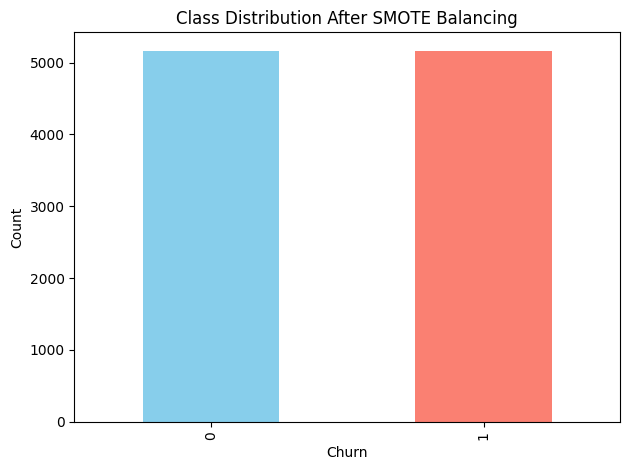

In [9]:
pd.Series(y_resampled).value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution After SMOTE Balancing')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(METRICS_DIR, 'class_distribution_after.png'))
plt.show()

In [10]:
# %% Split & Scale
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(PROCESSED_DIR, "scaler.pkl"))

['c:\\Users\\renit\\Desktop\\customer-churn-case-study\\data\\processed\\scaler.pkl']

In [11]:
# %% Config
model_types = ["logreg", "rf", "xgb"]
ENABLE_HYPERPARAM_TUNING = True

In [12]:
# %% get_model helper (NEW)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def get_model(model_type):
    if model_type == "logreg":
        return LogisticRegression(max_iter=1000)
    elif model_type == "rf":
        return RandomForestClassifier(random_state=42)
    elif model_type == "xgb":
        return XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

In [13]:
# %% Optional: hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grids = {
    "logreg": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear"]
    },
    "rf": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "class_weight": [None, "balanced"]
    },
    "xgb": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "scale_pos_weight": [1, sum(y_train==0)/sum(y_train==1)]
    }
}

best_params = {}


In [14]:
# %% Train models
for model_type in model_types:
    print(f"\n[Training {model_type.upper()}]")

    if ENABLE_HYPERPARAM_TUNING:
        print("Running hyperparameter tuning...")
        base_model = get_model(model_type)
        grid = GridSearchCV(base_model, param_grids[model_type], cv=3, scoring="roc_auc", n_jobs=-1)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        best_params[model_type] = grid.best_params_
        print(f"Best Params: {grid.best_params_}")
    else:
        model = train_model(X_train, y_train, model_type)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    X_test_df = pd.DataFrame(X_test, columns=X.columns)
    results_df = X_test_df.copy()
    results_df["Churn"] = y_test.values
    results_df["predicted"] = y_pred
    results_df["predicted_prob"] = y_prob

    pred_path = os.path.join(PREDICTIONS_DIR, f"predicted_{model_type}.csv")
    results_df.to_csv(pred_path, index=False)
    print(f"[✓] Saved predictions to: {pred_path}")

    model_path = os.path.join(PROCESSED_DIR, f"model_{model_type}.pkl")
    joblib.dump(model, model_path)

    if model_type in ["logreg","rf", "xgb"]:
        try:
            if model_type == "logreg":
                importances = np.abs(model.coef_[0])
            else:
                importances = model.feature_importances_
            importance_df = pd.DataFrame({
                "feature": X.columns,
                "importance": importances
            }).sort_values(by="importance", ascending=False)

            imp_path = os.path.join(FEATURE_IMPORTANCE_DIR, f"importance_{model_type}.csv")
            importance_df.to_csv(imp_path, index=False)
            print(f"[✓] Saved feature importances to: {imp_path}")
        except Exception as e:
            print(f"[!] Failed to extract feature importances: {e}")



[Training LOGREG]
Running hyperparameter tuning...
Best Params: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.8098
ROC-AUC: 0.9021
[✓] Saved predictions to: c:\Users\renit\Desktop\customer-churn-case-study\data\processed\predictions\predicted_logreg.csv
[✓] Saved feature importances to: c:\Users\renit\Desktop\customer-churn-case-study\data\processed\feature_importance\importance_logreg.csv

[Training RF]
Running hyperparameter tuning...
Best Params: {'class_weight': None, 'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.8359
ROC-AUC: 0.9215
[✓] Saved predictions to: c:\Users\renit\Desktop\customer-churn-case-study\data\processed\predictions\predicted_rf.csv
[✓] Saved feature importances to: c:\Users\renit\Desktop\customer-churn-case-study\data\processed\feature_importance\importance_rf.csv

[Training XGB]
Running hyperparameter tuning...
Best Params: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
Accuracy: 0.8228
ROC-AUC: 0.9213
[✓] Saved predictions to: c:\Users\renit\D

c:\Users\renit\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:16:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [15]:
# %% Save tuning summary (NEW)
if ENABLE_HYPERPARAM_TUNING:
    import json
    with open(os.path.join(METRICS_DIR, "best_params.json"), "w") as f:
        json.dump(best_params, f, indent=2)
    print("[✓] Saved best hyperparameters to best_params.json")

[✓] Saved best hyperparameters to best_params.json
